In [1]:
import sys
import argparse
import os
import numpy as np
from skimage.util import view_as_windows
from utilities.config_handler import get_config
from utilities.learning import split_train_validation, train_model, predict_ae_error_vectors
from utilities.detection import detect_reconstruction_anomalies_median,plot_spectogram_anomalies
from utilities.preprocessing import  add_noise,load_fft_test_data ,load_fft_train_data,  reshape_to_blocks,persist_object\
    ,load_object,persist_val_stat, load_val_stat ,get_xhdr_sample_rate , compute_fft_train_data , load_raw_data , compute_fft_train_data \
, compute_fft_test_data,trim_iq_basic_block, complex2power
compute_fft_train_data
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
import pandas as pd
from utilities.visualization import plot_spectogram
from scipy.stats import entropy
%matplotlib inline

Using TensorFlow backend.


In [2]:
normal_records = ['CELL_NORM_2', 'CELL_NORM_3', 'CELL_NORM_4']
anomal_records = ['CELL_SWP_18MHz_50us_0dB', \
          'CELL_SWP_18MHz_50us_10dB', 'CELL_SWP_18MHz_100us_0dB', 'CELL_SWP_18MHz_100us_10dB']

normal_path='iq_data/CELL/normal'
anomal_path='iq_data/CELL/anomal'

In [3]:
parser = argparse.ArgumentParser()
parser.prog = 'Spectrum Anomaly Detection'
parser.description = 'Use this command parser for training or testing the anomaly detector'
parser.add_argument('-m', '--mode', help='train or test mode', choices=['train', 'test'])
parser.add_argument('-d', '--data-dir', help='I/Q recording directory',nargs='?')
parser.add_argument('-w', '--weights-path', help='path for trained weights')


# sys.argv = "-m test -d -w model/baseline_gmm".split()
# sys.argv = "-m test -d iq_data/CELL/anomal/CELL_SWP_18MHz_50us_10dB -w model/baseline_gmm".split()
sys.argv = "-m train -d iq_data/CELL/normal/CELL_NORM_0 -w model/baseline_gmm".split()

namespace = parser.parse_args(sys.argv)
if not namespace.data_dir and namespace.mode == 'train':
    parser.error('the -d arg must be present when mode is train')
if not namespace.weights_path and namespace.mode == 'train':
    parser.error('the -w arg must be present when mode is train')

# if not namespace.data_dir and namespace.mode == 'test':
#     parser.error('the -d arg must be present when mode is test')

if not namespace.weights_path and namespace.mode == 'test':
    parser.error('the -w arg must be present when mode is test')
    
train = namespace.mode == 'train'

# Hyper parameters

In [4]:
conf=get_config()
gpus = conf['gpus']
lr=conf['learning']['ae']['lr']
validation_split = conf['learning']['ae']['validation_split']
train_params = conf['learning']['ae']
rbw_set = conf['preprocessing']['ae']['rbw_set']
feature_names = conf['preprocessing']['ae']['feature_names']
gmm_basic_time = conf['preprocessing']['gmm']['basic_time']
train = namespace.mode == 'train'


atom_height = 1
num_clusters = 500
cv_types = ['diag','spherical','tied']

In [5]:
def split_spectogram_to_atoms(spectogram,atom_height,stride=1):
    window_shape = (atom_height , spectogram.shape[1])
    return view_as_windows(spectogram,window_shape,step=stride).reshape(-1,*window_shape)

In [6]:
def fit_gmm(data,num_clusters,cv_types):
    lowest_bic = np.infty
    bic = []
    best_component=''
    best_cv=''
    best_gmm={}
    n_components_range = np.arange(2, num_clusters,200)
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = mixture.GaussianMixture(n_components=num_clusters, covariance_type=cv_type)
            gmm.fit(data)
            bic.append(gmm.bic(data))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_component = n_components
                best_cv = cv_type
                best_gmm = gmm
                print(best_cv)
                print(lowest_bic)
    print("best n_component {}".format(best_component))
    print("best gmm type {}".format(best_cv))
    return (best_component,best_cv, best_gmm)

In [7]:
def consecutive(data, stepsize=1):
    return [list(part) for part in np.split(data, np.where(np.diff(data) != stepsize)[0]+1)]

In [8]:
def train_gmm(data_dir,rbw,num_clusters):
    assert len(data_dir) != 0
    dataset_name = str.split(data_dir, '/')[1]
    recording_name = str.split(data_dir,'/')[-1]
    weights_dir = "_".join((dataset_name, str(rbw)))
    weights_path = os.path.join(namespace.weights_path, weights_dir)
    sample_rate = get_xhdr_sample_rate(data_dir)
    iq_data = load_raw_data(data_dir)
    iq_data = trim_iq_basic_block(iq_data , sample_rate,basic_time=gmm_basic_time)
    freqs, time, fft_train = compute_fft_train_data(iq_data,sample_rate,rbw,weights_path)
    print("Spectrogram length: {}".format(len(fft_train)))
    atom_fft_train = split_spectogram_to_atoms(fft_train,atom_height)
    flatten_atom_fft_train = atom_fft_train.reshape(len(atom_fft_train),-1)

    (best_component,best_cv, gmm) = fit_gmm(flatten_atom_fft_train,num_clusters,cv_types)
    train_likelihoods = -gmm.score_samples(flatten_atom_fft_train)
    best_params = {'best_component':best_component , 'best_cv':best_cv}
    persist_object(best_params ,os.path.join(weights_path,'gmm_best_params.pkl'))
    persist_object(gmm,os.path.join(weights_path,'gmm_clusters={}_cov={}_a={}.pkl'.\
                                            format(best_component,best_cv,atom_height)))
    persist_object(train_likelihoods,os.path.join(weights_path,\
                                            'train_likelihoods_clusters={}_cov={}_a={}.pkl'.\
                                    format(best_component,best_cv, atom_height)))


In [9]:
def test_gmm(data_dir,rbw,num_clusters):
    assert len(data_dir) != 0
    dataset_name = str.split(data_dir, '/')[1]
    recording_name = str.split(data_dir,'/')[-1]
    weights_dir = "_".join((dataset_name, str(rbw)))
    weights_path = os.path.join(namespace.weights_path, weights_dir)
    sample_rate = get_xhdr_sample_rate(data_dir)
    
    iq_data = load_raw_data(data_dir)
    iq_data = trim_iq_basic_block(iq_data , sample_rate,basic_time=gmm_basic_time)
    test_freqs, test_time, fft_test = compute_fft_test_data(iq_data,sample_rate,rbw,weights_path)
    
    atom_fft_test = split_spectogram_to_atoms(fft_test,atom_height)
    flatten_atom_fft_test = atom_fft_test.reshape(len(atom_fft_test),-1)
    
    best_params = load_object(os.path.join(weights_path,'gmm_best_params.pkl'))
    best_component = best_params['best_component']
    best_cv = best_params['best_cv']
    
    gmm = load_object(os.path.join(weights_path,'gmm_clusters={}_cov={}_a={}.pkl'.\
                                    format(best_component,best_cv, atom_height)))
    train_likelihoods = load_object(os.path.join(weights_path,\
                                            'train_likelihoods_clusters={}_cov={}_a={}.pkl'.\
                                    format(best_component,best_cv, atom_height)))

    window_shape = (atom_height , atom_fft_test.shape[1] // atom_height)
    score_spectogram = np.ones_like(atom_fft_test)
    test_liklihoods = -gmm.score_samples(flatten_atom_fft_test)

    anomalies_indices = np.argwhere(test_liklihoods > train_likelihoods)

    f, (ax1,ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,15))
    percent_anomalies = len(anomalies_indices) / len(test_liklihoods) * 100
    ax1.plot(np.sort(test_liklihoods))
    ax1.set_title('Test likelihoods, clusters={0:d} ,atom height {1}, num anomolous atoms {2:.2f}%'.\
                                    format(best_component, atom_height,percent_anomalies))
    
    ax2.plot(np.sort(train_likelihoods))
    ax2.set_title('Train likelihoods,clusters={0:d} ,atom height {1}'.\
                  format(best_component,atom_height))

    distances_plot_path = os.path.join(data_dir ,'likelihood_plot_clusters={}_{}_a={}_{}.png'.\
                                    format(best_component,best_cv, atom_height,recording_name))
    plt.savefig(distances_plot_path)

#     fig, ax = plt.subplots(figsize=(20,20))
#     anomalies_blocks = consecutive(anomalies_indices)
#     ax.imshow(fft_test,aspect='auto', origin='upper')
#     if len(anomalies_indices) > 0:
#         anomalies_plot_path = os.path.join(data_dir ,'cluster_anomalies_k={}_a={}_{}.png'.\
#                                        format(num_clusters,atom_height,recording_name))
#         for block in anomalies_blocks:
#             x_cord = 0
#             y_cord = block[0]
#             block_height , block_width = len(block) + 1,fft_test.shape[1]
#             rect = patches.Rectangle((x_cord,y_cord),block_width-1,block_height,edgecolor='r',\
#                                      facecolor='r',fill=True,alpha=0.5,linewidth=0.1,rasterized=True)
#             ax.add_patch(rect)

#     plt.savefig(anomalies_plot_path)    

In [ ]:
if train:
    data_dir=namespace.data_dir
    for rbw in rbw_set:
        train_gmm(data_dir,rbw,num_clusters)
            
else:
    if not namespace.data_dir:
        for r in normal_records:
            data_dir = os.path.join(normal_path, r)
            for rbw in rbw_set:
                test_gmm(data_dir,rbw,num_clusters)

        for r in anomal_records:
            data_dir = os.path.join(anomal_path,r)
            for rbw in rbw_set:
                test_gmm(data_dir,rbw,num_clusters)

    else:
        data_dir = namespace.data_dir
        assert len(data_dir) != 0
        for rbw in rbw_set:
            test_gmm(data_dir,rbw,num_clusters)

# Experiements

In [10]:
normal_data_dir = 'iq_data/CELL/normal/CELL_NORM_0'
anomaly_data_dir = 'anomal/CELL_SWP_18MHz_50us_0dB'
rbw = 125e3
dataset_name = str.split(normal_data_dir, '/')[1]
recording_name = str.split(normal_data_dir,'/')[-1]
weights_dir = "_".join((dataset_name, str(rbw)))
weights_path = os.path.join('model/baseline_gmm', weights_dir)
sample_rate = get_xhdr_sample_rate(normal_data_dir)

iq_data = load_raw_data(normal_data_dir)
iq_data = trim_iq_basic_block(iq_data , sample_rate,basic_time=1e-2)
freqs, time, fft_train = compute_fft_train_data(iq_data,sample_rate,rbw,weights_path)
print("Spectrogram length: {}".format(len(fft_train)))
atom_fft_train = split_spectogram_to_atoms(fft_train,atom_height)
flatten_atom_fft_train = atom_fft_train.reshape(len(atom_fft_train),-1)

Spectrogram length: 4997


In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
pca_train = pca.fit_transform(flatten_atom_fft_train)

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=20)
tsne_train = tsne.fit_transform(flatten_atom_fft_train)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 4997 samples in 0.094s...
[t-SNE] Computed neighbors for 4997 samples in 22.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4997
[t-SNE] Computed conditional probabilities for sample 2000 / 4997
[t-SNE] Computed conditional probabilities for sample 3000 / 4997
[t-SNE] Computed conditional probabilities for sample 4000 / 4997
[t-SNE] Computed conditional probabilities for sample 4997 / 4997
[t-SNE] Mean sigma: 49.805483
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.135239
[t-SNE] Error after 1000 iterations: 1.743078


In [18]:
anomaly_data_dir = 'iq_data/CELL/normal/CELL_NORM_4'
rbw = 125e3
dataset_name = str.split(anomaly_data_dir, '/')[1]
recording_name = str.split(anomaly_data_dir,'/')[-1]
weights_dir = "_".join((dataset_name, str(rbw)))
weights_path = os.path.join('model/baseline_gmm', weights_dir)
sample_rate = get_xhdr_sample_rate(anomaly_data_dir)
iq_data = load_raw_data(anomaly_data_dir)
iq_data = trim_iq_basic_block(iq_data , sample_rate,basic_time=1e-2)
freqs, time, fft_test = compute_fft_train_data(iq_data,sample_rate,rbw,weights_path)
print("Spectrogram length: {}".format(len(fft_test)))
atom_fft_test = split_spectogram_to_atoms(fft_test,atom_height)
flatten_atom_fft_test = atom_fft_test.reshape(len(atom_fft_test),-1)

Spectrogram length: 4997


In [19]:
pca_test = pca.transform(flatten_atom_fft_test)
tsne_test = tsne.fit_transform(flatten_atom_fft_test)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 4997 samples in 0.105s...
[t-SNE] Computed neighbors for 4997 samples in 24.914s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4997
[t-SNE] Computed conditional probabilities for sample 2000 / 4997
[t-SNE] Computed conditional probabilities for sample 3000 / 4997
[t-SNE] Computed conditional probabilities for sample 4000 / 4997
[t-SNE] Computed conditional probabilities for sample 4997 / 4997
[t-SNE] Mean sigma: 49.465767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.666954
[t-SNE] Error after 1000 iterations: 1.719552


In [20]:
pca_test.shape

(4997, 2)

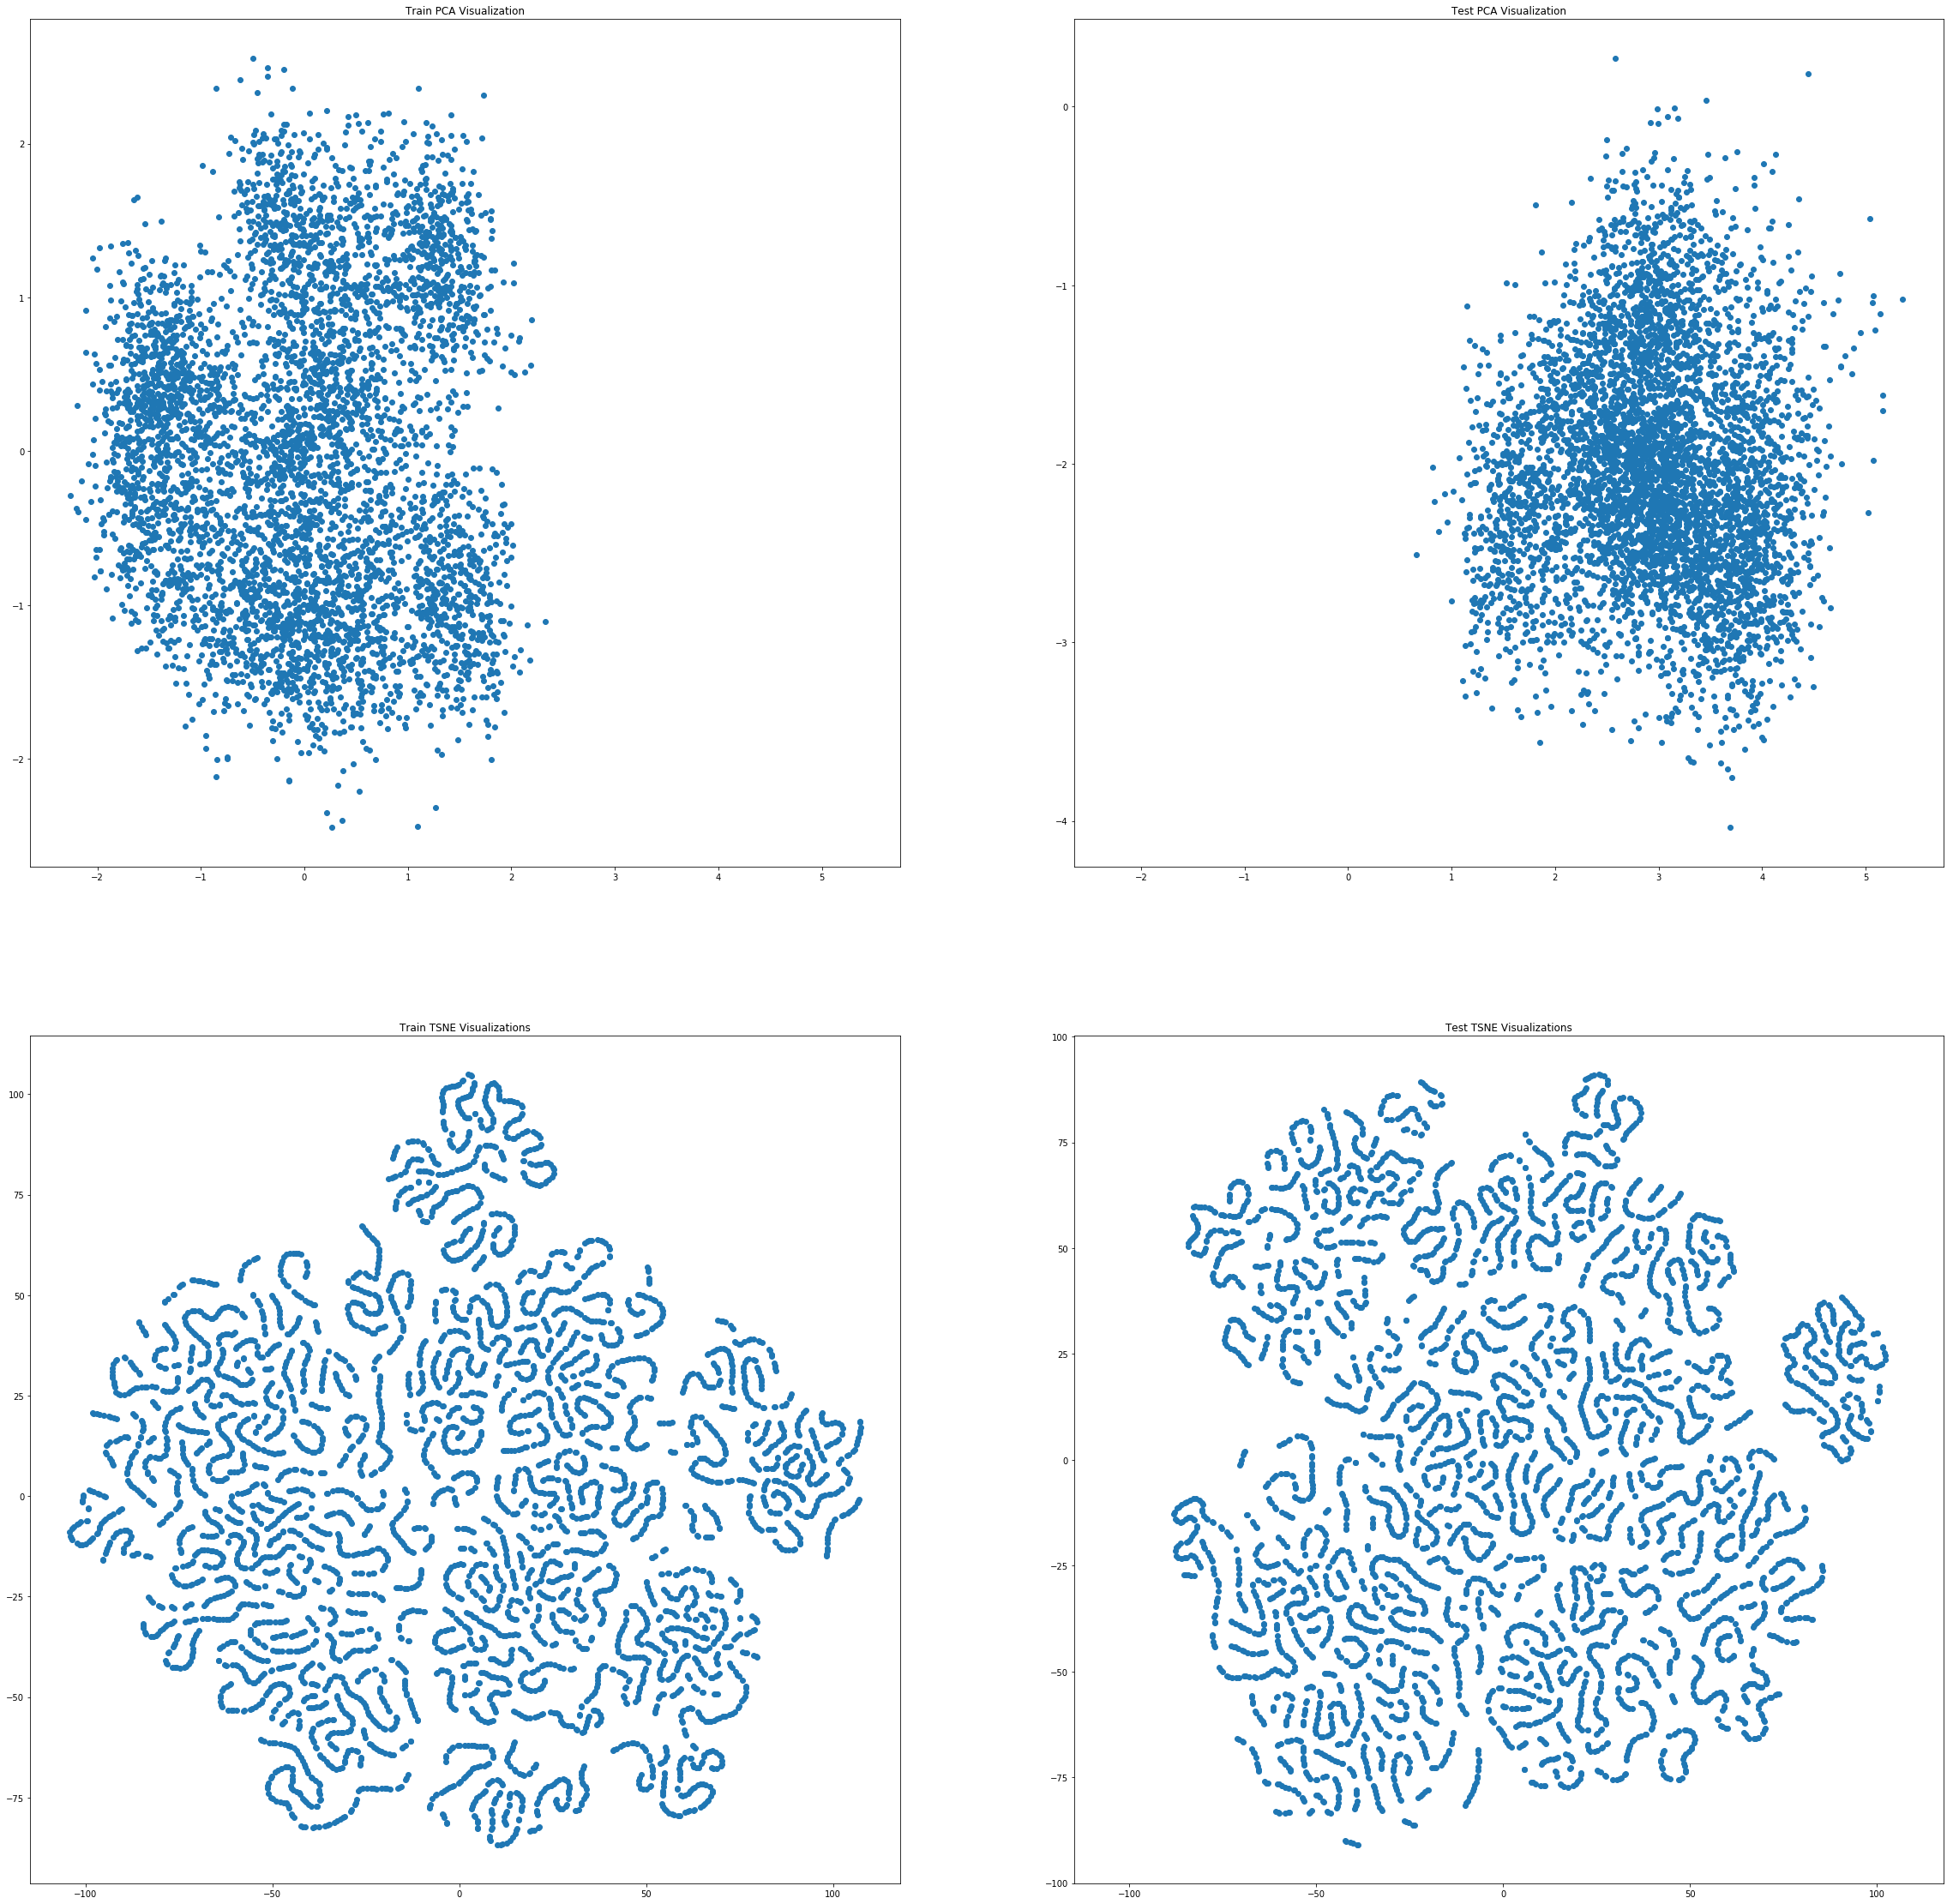

In [21]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex='row',figsize=(40,40))

ax1.scatter(pca_train[:,0],pca_train[:,1])
ax1.set_title("Train PCA Visualization")

ax2.scatter(pca_test[:,0],pca_test[:,1])
ax2.set_title("Test PCA Visualization")


ax3.scatter(tsne_train[:,0],tsne_train[:,1])
ax3.set_title("Train TSNE Visualizations")


ax4.scatter(tsne_test[:,0],tsne_test[:,1])
ax4.set_title("Test TSNE Visualizations")
plt.show()

In [22]:
pca.explained_variance_ratio_

array([0.04281811, 0.01818481], dtype=float32)